In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import scipy.constants as ct
import sympy as smp
from scipy.optimize import curve_fit


samples_names = ['a581','c262','c263','no_name']
intervals_list = [[810,870],[800,840],[730,790],[730,790]]

def fit_function(hw, E1, T1, C1, E2, T2, C2, sigma):

    def I_smooth(hw, E_activate, T, const, sigma=sigma):
        hw = np.asarray(hw)
        a = ct.e / ct.k / T

        z = (E_activate - hw + a*sigma**2) / (np.sqrt(2)*sigma)

        # разложим экспоненту
        base = a*(E_activate - hw)

        # сдвигаем, чтобы не переполнялось:
        # exp(base) = exp(base - z*z) * exp(z*z)
        return 0.5 * const * np.exp(base - z*z) * sp.special.erfcx(z)

    return I_smooth(hw, E1, T1, C1, sigma) + I_smooth(hw, E2, T2, C2, sigma)


class Sample:


    def calc_EE(self, graph=False):
        me_in = self.me_in/ct.m_e
        mhh_in = self.mhh_in/ct.m_e
        me_out = self.me_out/ct.m_e
        mhh_out = self.mhh_out/ct.m_e

        hbar = 1.054571817e-34
        eV = 1.602176634e-19
        me = ct.m_e

        U0e = 0.6 * self.Eg
        U0h = 0.4 * self.Eg
        
        def ae(E):
            return (hbar/2/self.me_in/E/eV)**0.5 * np.arctan((me_out/me_in*(U0e/E-1))**0.5)
        def ah(E):
            E = self.deltaE - E
            return (hbar/2/self.mhh_in/E/eV)**0.5 * np.arctan((mhh_out/mhh_in*(U0h/E-1))**0.5)
        def f(E):
            return ae(E) - ah(E)
        Ee = sp.optimize.fsolve(f, self.deltaE/2)[0]
        self.Ee = Ee
        self.Eh = self.deltaE - Ee
        self.a = ae(Ee) * 1e-9  # in meters
        np_arr = np.linspace(-0.1, 0.1, 1000)
        plt.plot(np_arr, ae(np_arr), label='ae(Ee)')
        plt.plot(np_arr, ah(np_arr), label='ah(Eh)')
        plt.legend()
        if graph:
            plt.show()
        else:
            plt.close()
        
    

    def __init__(self, name, aluminium=0, interval = [400, 1000]):
        self.name = name
        self.interval = interval
        self.aluminium = aluminium

        self.interval_ev = [2*np.pi * ct.hbar *ct.c / (interval[1]*1e-9) / ct.e, 2*np.pi * ct.hbar  *ct.c / (interval[0]*1e-9) / ct.e]
        self.data = pd.read_csv(f'./data_for_python/{name}.csv', sep=' ')[1:]
        self.data.columns = ["lambda", "I"]
        self.data["omega"] = 2*np.pi *ct.c /self.data["lambda"]*10**9
        self.data["ev"] = self.data["omega"] * ct.hbar / ct.e
        self.data_filtered = self.data.copy()
        self.data_filtered = self.data_filtered[
            (self.data["lambda"] >= self.interval[0]) &
            (self.data["lambda"] <= self.interval[1])
        ]
        self.data_filtered = self.data_filtered.reset_index(drop=True)



        self.T_hh = 0
        self.T_lh = 0
        self.T_h = 0

        self.Eg = 1.424  # eV for GaAs at 300K
        self.me_out = 0.067 * ct.m_e  # effective mass of electron in GaAs
        self.mhh_out = 0.45 * ct.m_e  # effective mass
        self.mlh_out = 0.082 * ct.m_e  # effective mass

        self.me_in = self.me_out + 0.083 * ct.m_e * self.aluminium # effective mass of electron
        self.mhh_in = self.mhh_out + (0.08-0.082) * ct.m_e * self.aluminium # effective mass of heavy hole
        self.mlh_in = self.mlh_out + (0.4-0.45) * ct.m_e * self.aluminium # effective mass of light hole

        
    def plot_spectrum(self):
        plt.plot(self.data["ev"], self.data["I"], label=self.name)
        plt.xlabel("Energy (eV)")
        plt.ylabel("Intensity (a.u.)")
        plt.title(f"Spectrum of {self.name}")
        plt.legend()
        plt.show()

    def filter_data(self, kernel_size=5, window_length=11, polyorder=3):
        
        self.data_filtered["I"] = sp.signal.medfilt(self.data_filtered["I"], kernel_size=kernel_size)   # 3, 5 или 7
        self.data_filtered["I"]= sp.signal.savgol_filter(self.data_filtered["I"], window_length=window_length, polyorder=polyorder, axis=0)
        self.data_filtered["I"] = self.data_filtered["I"] - np.min(self.data_filtered["I"])

    def print_data(self):
        print(f"Sample {self.name}: T_h = {self.T_h} K, T_hh = {self.T_hh:.2f} K, T_lh = {self.T_lh:.2f} K, DeltaE = {self.deltaE:.3f} eV, Ee = {self.Ee:.3f} eV, Eh = {self.Eh:.3f} eV, a = {self.a:.3e} m")

    def find_2_peaks(self):
        peaks, properties = sp.signal.find_peaks(self.data_filtered["I"], prominence=0.1, width=0.01)   
        prominences = properties['prominences']
        sorted_by_prominence = np.argsort(prominences)[::-1]
        # Берем два самых значимых пика
        top_2_peaks = peaks[sorted_by_prominence[:2]]

        top_2_prominences = prominences[sorted_by_prominence[:2]]
        # for peak, prominence in zip(top_2_peaks, top_2_prominences):
        #     # plt.plot(self.data_filtered["ev"].iloc[peak], self.data_filtered["I"].iloc[peak], "x", color="purple", markersize=20)
        #     # plt.text(self.data_filtered["ev"].iloc[peak], self.data_filtered["I"].iloc[peak], f'hw = {self.data_filtered["ev"].iloc[peak]:.3f} eV', fontsize=8, verticalalignment='bottom')
        self.deltaE = abs(self.data_filtered["ev"].iloc[top_2_peaks[0]] - self.data_filtered["ev"].iloc[top_2_peaks[1]])
        self.ev_peak1 = self.data_filtered["ev"].iloc[top_2_peaks[0]]
        self.ev_peak2 = self.data_filtered["ev"].iloc[top_2_peaks[1]]
    def calc_sample(self, init_params, try_fit=False, graph_fit=False,maxfev=10000):
        self.find_2_peaks()

        if(try_fit==True):
            if(graph_fit==True):
                plt.plot(self.data_filtered["ev"], self.data_filtered["I"], 'b.', label='Data')
                plt.xlabel("Energy (eV)")
                plt.ylabel("Intensity (a.u.)")
                plt.title(f"Fit of {self.name}")
                plt.plot(self.data_filtered["ev"], fit_function(self.data_filtered["ev"], *init_params), 'g-', label='init_Fit')

            p_otim, p_cov = curve_fit(fit_function, self.data_filtered["ev"], self.data_filtered["I"], p0=init_params, maxfev=maxfev)
            self.p_optim = p_otim
            self.T_hh = p_otim[1]
            self.T_lh = p_otim[4]
            if(graph_fit==True):
                plt.plot(self.data_filtered["ev"], fit_function(self.data_filtered["ev"], *p_otim), 'r-', label='Fit')
                plt.legend()
                plt.show()
    def get_params_from_fit(self):
        self.T_lh = self.p_optim[1]
        self.T_hh = self.p_optim[4]
        self.ev_peak1 = min(self.p_optim[0], self.p_optim[3])
        self.ev_peak2 = max(self.p_optim[0], self.p_optim[3])


    def calc_temperature_with_log(self,tail=0.05,kernel_size=9,plt_show=True):
        hv_cut = self.ev_peak2 + 0.01
        data_srez = self.data[(self.data["ev"] >= hv_cut) & (self.data["ev"] <= hv_cut + tail)]
        data_srez = data_srez.reset_index(drop=True)
        
        # linear fit of ln(I) vs ev -> slope = -e/(k*T)
        # data_srez["I"] = sp.signal.medfilt(data_srez["I"], kernel_size=kernel_size)   # 3, 5 или 7
        # data_srez["I"] = data_srez["I"] - np.min(data_srez["I"])

        data_srez["ln_I"] = np.log(data_srez["I"])
        slope, intercept = np.polyfit(data_srez["ev"], data_srez["ln_I"], 1)
        # plot ln(I) vs ev and the linear fit
        plt.figure()
        plt.plot(data_srez["ev"], data_srez["ln_I"], 'b.', label='ln(I) data')
        ev_fit = np.linspace(data_srez["ev"].min(), data_srez["ev"].max(), 200)
        ln_fit = slope * ev_fit + intercept
        self.T_h = -ct.e / (slope * ct.k)
        plt.plot(ev_fit, ln_fit, 'r-', label=f'fit: ln(I) = {slope:.4e}*E + {intercept:.4e}')
        plt.xlabel("Energy (eV)")
        plt.ylabel("ln(I)")
        plt.title(f"Linear fit for {self.name}")
        plt.legend()
        plt.savefig(f"{self.name}_log_fit.png")
        if plt_show:
            plt.show()
        else:
            plt.close()

    def plot_sample(self):
        
        plt.plot(self.data_filtered["ev"], self.data_filtered["I"], 'b.', label='Data')
        if hasattr(self, 'p_optim'):
            plt.plot(self.data_filtered["ev"], fit_function(self.data_filtered["ev"], *self.p_optim), 'r-', label='Fit')
            plt.plot()
        try:
            plt.plot(self.data_filtered["ev"].iloc[self.ev_peak1], self.data_filtered["I"].iloc[self.ev_peak1], "x", color="purple", markersize=20)
            plt.text(self.data_filtered["ev"].iloc[self.ev_peak1], self.data_filtered["I"].iloc[self.ev_peak1], f'hw = {self.data_filtered["ev"].iloc[self.ev_peak1]:.3f} eV', fontsize=8, verticalalignment='bottom')
        except:
            if hasattr(self, 'p_optim'):
                plt.plot(self.ev_peak1, fit_function(self.ev_peak1, *self.p_optim), "x", color="purple", markersize=20)
                plt.text(self.ev_peak1, fit_function(self.ev_peak1, *self.p_optim), f'hw = {self.ev_peak1:.3f} eV', fontsize=8, verticalalignment='bottom')
        plt.xlabel("Energy (eV)")
        plt.ylabel("Intensity (a.u.)")
        plt.title(f"Fit of {self.name}")
        plt.savefig(f"{self.name}_fit.png")
        plt.legend()
        plt.show()



fit_function(1.45,1.45,300,1,0,100,0,200)

np.float64(0.0)

In [4]:

a581 = Sample('a581', interval=[810, 870],aluminium=0.352)
c262 = Sample('c262', interval=[770, 840],aluminium=0.25)
c263 = Sample('c263', interval=[730, 790],aluminium=0.25)
no_name = Sample('no_name', interval=[730, 790],aluminium=0.25)

C:\Users\RedBrean\AppData\Local\Temp\ipykernel_11072\2533842686.py:26: RuntimeWarning: invalid value encountered in multiply
  return 0.5 * const * np.exp(base - z*z) * sp.special.erfcx(z)


np.float64(0.21877883597577844)

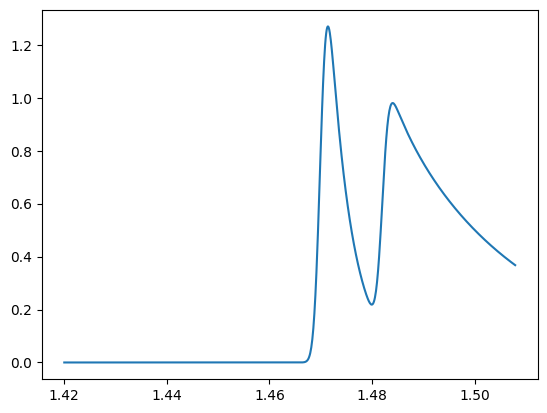

In [66]:
x=np.linspace(1.42,1.52,1000)
p0=[1.47, 50, 2, 1.482, 300, 1, 0.001]
plt.plot(x,fit_function(x,*p0))
fit_function(1.48,*p0)

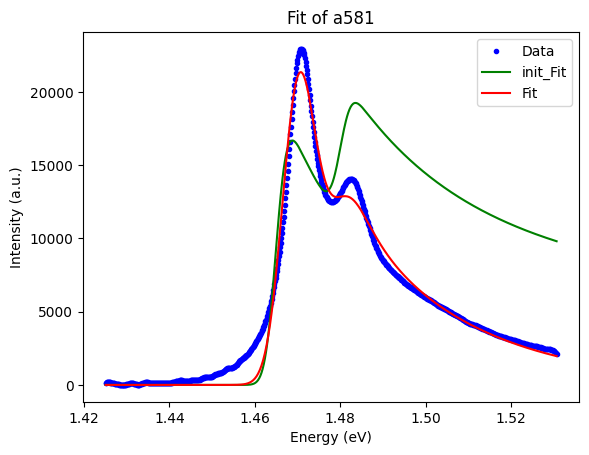

[1.46782122e+00 5.45548228e+01 7.03548853e+04 1.47870103e+00
 3.16719281e+02 1.31512895e+04 3.35841236e-03]


In [62]:

a581.filter_data()
a581.calc_sample(init_params=[1.465, 300, 20000, 1.48, 3000, 10000, 0.002], try_fit=True, graph_fit=True)   
print(a581.p_optim) 


In [ ]:

c262.filter_data(window_length=30)
c262.calc_sample(init_params=[1.495, 250, 300000, 1.51, 200, 700000,400], try_fit= True,graph_fit=False, maxfev=30000)



0.021543333155362946
0.017234666524290357
0.021543333155362946
0.017234666524290357
0.021543333476383625
0.017234666524290357
0.021543333155362946
0.017234666524290357
0.021543333155362946
0.017234666524290357
0.021543333155362946
0.0172346667811069
0.021543333155362946
0.017234666524290357
0.021543333155362946
0.017234666524290357


C:\Users\RedBrean\AppData\Local\Temp\ipykernel_21524\1281927944.py:137: OptimizeWarning: Covariance of the parameters could not be estimated
  p_otim, p_cov = curve_fit(fit_function, self.data_filtered["ev"], self.data_filtered["I"], p0=init_params, maxfev=maxfev)


In [ ]:
c263.filter_data(window_length=11)
c263.calc_sample(init_params=[1.60, 300, 200000, 1.64, 300, 500000,400], try_fit=True, graph_fit=False)


0.025851999786435535
0.025851999786435535
0.025851999786435535
0.025851999786435535
0.025852000171660353
0.025851999786435535
0.025851999786435535
0.025851999786435535
0.025851999786435535
0.025851999786435535
0.025851999786435535
0.025852000171660353
0.025851999786435535
0.025851999786435535
0.025851999786435535
0.025851999786435535


C:\Users\RedBrean\AppData\Local\Temp\ipykernel_21524\1281927944.py:137: OptimizeWarning: Covariance of the parameters could not be estimated
  p_otim, p_cov = curve_fit(fit_function, self.data_filtered["ev"], self.data_filtered["I"], p0=init_params, maxfev=maxfev)


In [ ]:
no_name.filter_data(window_length=20)
no_name.calc_sample(init_params=[1.61, 300, 1000000, 1.64, 300, 500000,400], try_fit=True, graph_fit=False)

0.025851999786435535
0.025851999786435535
0.025851999786435535
0.025851999786435535
0.025852000171660353
0.025851999786435535
0.025851999786435535
0.025851999786435535
0.025851999786435535
0.025851999786435535
0.025851999786435535
0.025852000171660353
0.025851999786435535
0.025851999786435535
0.025851999786435535
0.025851999786435535


C:\Users\RedBrean\AppData\Local\Temp\ipykernel_21524\1281927944.py:137: OptimizeWarning: Covariance of the parameters could not be estimated
  p_otim, p_cov = curve_fit(fit_function, self.data_filtered["ev"], self.data_filtered["I"], p0=init_params, maxfev=maxfev)


C:\Users\RedBrean\AppData\Local\Temp\ipykernel_21524\1281927944.py:41: RuntimeWarning: invalid value encountered in sqrt
  return (hbar/2/self.me_in/E/eV)**0.5 * np.arctan((me_out/me_in*(U0e/E-1))**0.5)
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_21524\1281927944.py:44: RuntimeWarning: invalid value encountered in sqrt
  return (hbar/2/self.mhh_in/E/eV)**0.5 * np.arctan((mhh_out/mhh_in*(U0h/E-1))**0.5)


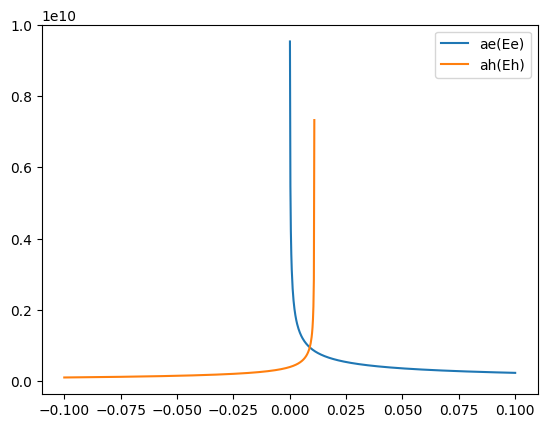

Sample a581: T_h = 338.5650285700074 K, T_hh = 300.00 K, T_lh = 300.00 K, DeltaE = 0.011 eV, Ee = 0.009 eV, Eh = 0.002 eV, a = 9.420e-01 m
0.025851999786435535
0.025851999786435535
0.025851999786435535
0.025851999786435535
0.025851999786435535
0.025851999786435535


c:\Users\RedBrean\AppData\Local\Programs\Python\Python314\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_21524\1281927944.py:19: RuntimeWarning: overflow encountered in exp
  return 0.5 * C * np.exp(-E_d/a + (sigma/a)**2/2) * sp.special.erfcx((sigma**2 - a*E_d)/np.sqrt(2)/sigma/a) * np.heaviside(E_d-1,0)
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_21524\1281927944.py:19: RuntimeWarning: invalid value encountered in scalar multiply
  return 0.5 * C * np.exp(-E_d/a + (sigma/a)**2/2) * sp.special.erfcx((sigma**2 - a*E_d)/np.sqrt(2)/sigma/a) * np.heaviside(E_d-1,0)


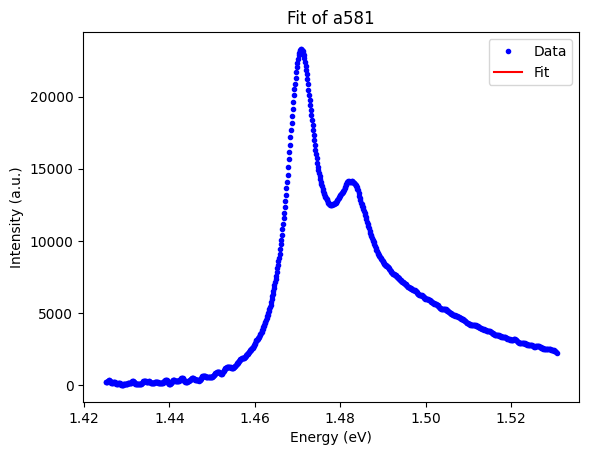

In [ ]:
a581.calc_EE(True)
a581.calc_temperature_with_log(plt_show=False)
a581.print_data()
a581.plot_sample()

In [ ]:
c262.calc_EE()
c262.print_data()


Sample c262: T_h = 0 K, T_hh = 250.00 K, T_lh = 200.00 K, DeltaE = 0.021 eV, Ee = 0.018 eV, Eh = 0.004 eV, a = 6.816e-01 m


C:\Users\RedBrean\AppData\Local\Temp\ipykernel_21524\1281927944.py:41: RuntimeWarning: invalid value encountered in sqrt
  return (hbar/2/self.me_in/E/eV)**0.5 * np.arctan((me_out/me_in*(U0e/E-1))**0.5)
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_21524\1281927944.py:44: RuntimeWarning: invalid value encountered in sqrt
  return (hbar/2/self.mhh_in/E/eV)**0.5 * np.arctan((mhh_out/mhh_in*(U0h/E-1))**0.5)
